<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#Длина-знаков-и-слов-в-классах" data-toc-modified-id="Длина-знаков-и-слов-в-классах-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Длина знаков и слов в классах</a></span></li><li><span><a href="#Встречаемость-слов-в-в-классах" data-toc-modified-id="Встречаемость-слов-в-в-классах-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Встречаемость слов в в классах</a></span></li></ul></li><li><span><a href="#Подготовка-данных-к-обучению-модели" data-toc-modified-id="Подготовка-данных-к-обучению-модели-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных к обучению модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для анализа токсичности комментариев пользователей

**Задача**

Построить модель классификации для поиска токсичных комментариев пользователей. Поиск токсичных комментарив необходим, чтобы в дальнейшем автоматически отправлять их на модерацию. 
В качестве оценки качества модели была выбрана `F1`, значение которой должно быть не меньше 0.75. 

**Описание данных**

В наличие были данные с разметкой на позитивные и негативные сообщения.
Колонка `text` содержит текст комментария, а `toxic` — разметку.

## Подготовка

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

import re
import nltk
import collections
from nltk.corpus import stopwords
import collections

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

import torch
import transformers
from transformers import BertTokenizer, BertModel
from tqdm import notebook

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_auc_score 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve

In [2]:
warnings.filterwarnings('ignore')

* Для получения контекстуальных эмбедингов обратимся к предобученной модели `unitary/toxic-bert`, которую обучали на токсичность комментарирев.
https://huggingface.co/unitary/toxic-bert

In [ ]:
# Поместим установку необходимой библиотеки в самом начале тетрадки
model = BertModel.from_pretrained('unitary/toxic-bert',
                                  output_hidden_states = True, 
                                  )
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')


Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

In [3]:
# Импорируем таблицу с текстами
path = '/datasets/toxic_comments.csv'
path2 = r'D:/Yandex/Модуль 3/Тексты/toxic_comments.csv'
list_of_pathes = [path, path2]

comments = [pd.read_csv(path) for path in list_of_pathes if os.path.exists(path)][0]

In [ ]:
#Функция получения информации о таблице
def df_info(df):
    display(df.head())
    print()
    print('Объем таблицы', df.shape)
    print()
    print('Информация о таблице', df.info())
    print()
    print('Пропуски')
    print(df.isna().sum())
   
    print()
    print('Дубликаты', df.duplicated().sum())


In [ ]:
df_info(comments)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



Объем таблицы (159571, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
Информация о таблице None

Пропуски
text     0
toxic    0
dtype: int64

Дубликаты 0


* Таблица `comments` содержит 159571 строк и два столбца - с текстами и разметкой.
* В таблица не содержит пропусков и дубликатов.
* Формат строк верный.
* Отберем первые 1000 строк из таблицы для отработки метода `BERT`.


In [5]:
comments_1 = comments[:1000]

### EDA

#### Баланс классов

* Посмотрим на баланс между классами.

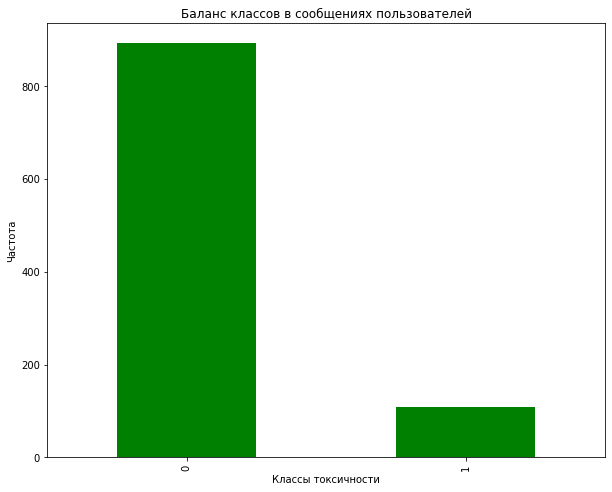

0    892
1    108
Name: toxic, dtype: int64


In [ ]:
comments_1['toxic'].value_counts().plot(kind='bar', figsize=(10,8), color='g')
plt.title('Баланс классов в сообщениях пользователей')
plt.ylabel('Частота')
plt.xlabel('Классы токсичности')
plt.show()

print(comments_1['toxic'].value_counts())


* Дисбаланс в пользу нетоксичных классов, значит целевые сообщения находятся в меньшинстве.

#### Длина знаков и слов в классах

* Посмотрим на длину сообщений для обоих классов.

Харакетистики длины нетоксичных комментариев count     892.000000
mean      423.586323
std       602.978866
min        19.000000
25%       105.000000
50%       221.000000
75%       506.000000
max      4722.000000
Name: text, dtype: float64

Харакетистики длины токсичных комментариев count     108.000000
mean      256.157407
std       346.202959
min        22.000000
25%        63.000000
50%       126.000000
75%       313.000000
max      2055.000000
Name: text, dtype: float64


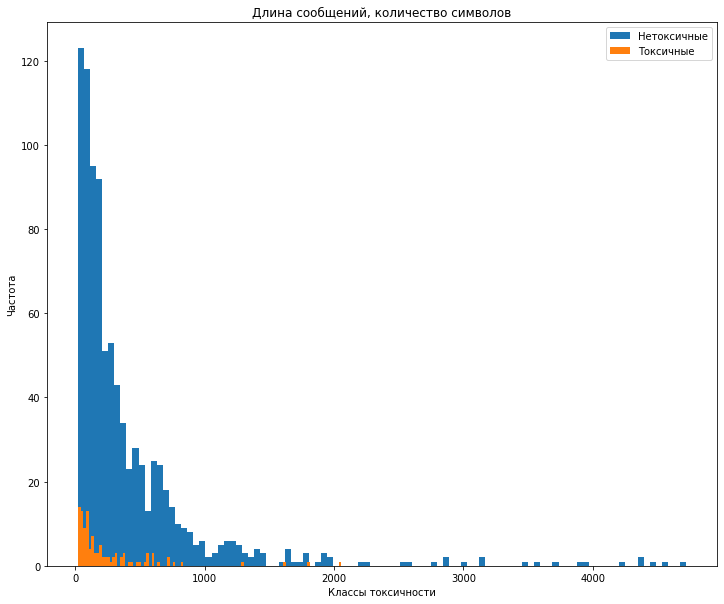

In [ ]:
comments_1.query('toxic==0')['text'].str.len().hist(bins=100, grid=False, figsize=(12,10))
comments_1.query('toxic==1')['text'].str.len().hist(bins=100, grid=False, figsize=(12,10))

print('Харакетистики длины нетоксичных комментариев', comments_1.query('toxic==0')['text'].str.len().describe())
print()
print('Харакетистики длины токсичных комментариев', comments_1.query('toxic==1')['text'].str.len().describe())

plt.title('Длина сообщений, количество символов')
plt.ylabel('Частота')
plt.xlabel('Классы токсичности')

plt.legend(labels=['Нетоксичные', 'Токсичные'])
plt.show()

* Токсичные сообщения короче по количеству символов в строке, чем нетоксичные.
* Посмотрим также на количество слов в строке.


Харакетистики длины нетоксичных комментариев count     892.000000
mean      423.586323
std       602.978866
min        19.000000
25%       105.000000
50%       221.000000
75%       506.000000
max      4722.000000
Name: text, dtype: float64

Харакетистики длины токсичных комментариев count     108.000000
mean      256.157407
std       346.202959
min        22.000000
25%        63.000000
50%       126.000000
75%       313.000000
max      2055.000000
Name: text, dtype: float64


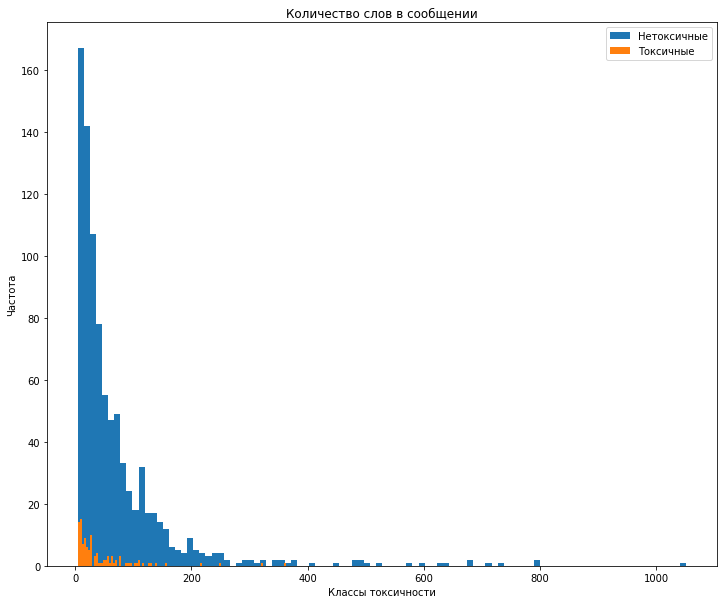

In [ ]:
comments_1.query('toxic==0')['text'].str.split().\
        apply(lambda x: len(x)).\
        hist(bins=100, grid=False,figsize=(12,10))

comments_1.query('toxic==1')['text'].str.split().\
        apply(lambda x: len(x)).\
        hist(bins=100, grid=False,figsize=(12,10))


print('Харакетистики длины нетоксичных комментариев', comments_1.query('toxic==0')['text'].str.len().describe())
print()
print('Харакетистики длины токсичных комментариев', comments_1.query('toxic==1')['text'].str.len().describe())

plt.title('Количество слов в сообщении')
plt.ylabel('Частота')
plt.xlabel('Классы токсичности')

plt.legend(labels=['Нетоксичные', 'Токсичные'])
plt.show()

* Количество слов, очевидно, также выше в нетоксичных сообщениях.

#### Встречаемость слов в в классах

* Бросим первый взгляд на встречаемость слов в позитивных и негативных сообщениях.

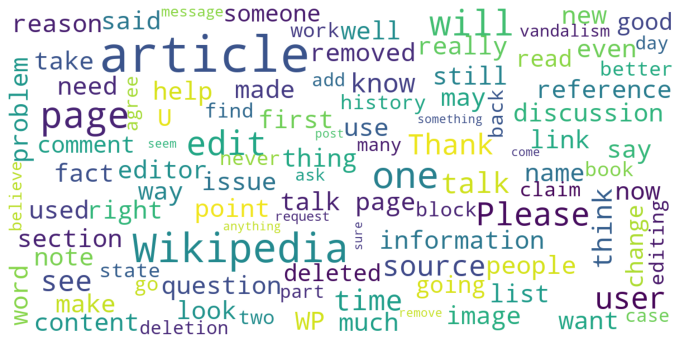

In [6]:
# Зададим список со стоп-словами:
stopwords = set(STOPWORDS)

# Зададим белый фон для вывода нетоксичных комментариев

wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

# Создадим строку из слов из нетоксичных сообщений
non_toxic = " ".join(word for word in comments_1.query('toxic==0')['text'])

   
wordcloud=wordcloud.generate(str(non_toxic))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()


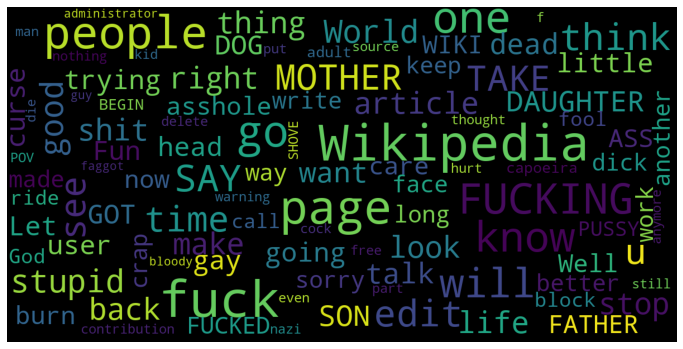

In [7]:
# Зададим чёрный фон для вывода токсичных комментариев
wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

# Создадим строку из слов из токсичных сообщений
toxic = " ".join(word for word in comments_1.query('toxic==1')['text'])
   
wordcloud=wordcloud.generate(str(toxic))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

* Из облака слов сразу видно, что среди негативных комментариях встречаются слова из нецензурной лексики, а также слова, прописанные заглавными буквами, что может отражать эмоциональное состояние этих людей в момент написания комментария. 
* В облаке слов позитивных комментариев не отмечены вышеупомянутые признаки.


* Посмотрим теперь на самые распространенные слова в классах. Для этого проведем лемматизацию слов, уберём лишние знаки, кроме латинского алфавита и приведем все буквы к нижнему регистру (т.к. словарь стоп слов содержит только нижний регистр).

In [9]:
# Создадим функцию очистки текста
lemmatizer = WordNetLemmatizer()

def text_clear(text):
    text_lower = str.lower(text)
    lemm_list = lemmatizer.lemmatize(text_lower)
    lemm_text = "".join(lemm_list)
    text_clear = re.sub(r'[^a-zA-Z]', ' ', lemm_text)
    text_split = ' '.join(text_clear.split()) 

    
    return text_split



In [26]:
# Создадим корпус нетоксичных комментариев
corpus_nontoxic = comments_1.query('toxic==0')['text'].apply(text_clear).str.split()

# Создадим корпус токсичных комментариев
corpus_toxic = comments_1.query('toxic==1')['text'].apply(text_clear).str.split()

In [11]:
# Создадим корпус нетоксичных комментариев без стоп слов
corpus_nontoxic = [word for text in corpus_nontoxic for word in text if word not in stopwords.words('english')]

# Создадим корпус токсичных комментариев без стоп слов
corpus_toxic = [word for text in corpus_toxic for word in text if word not in stopwords.words('english')]

In [ ]:
# Создадим функцию графика популярных слов
def plot_pop_words(corpus):
 
    # Посчитаем наиболее популярные слова
    counter_corpus = collections.Counter(corpus).most_common(100)

    
    
    # Построим график 20 популярных слов
    plt.figure(figsize=(12,8))
    stop=set(stopwords.words('english'))
    x, y= [], []
    for word,count in counter_corpus[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)
        
    sns.barplot(x=y,y=x)

       
    plt.xlabel('Частота')
    

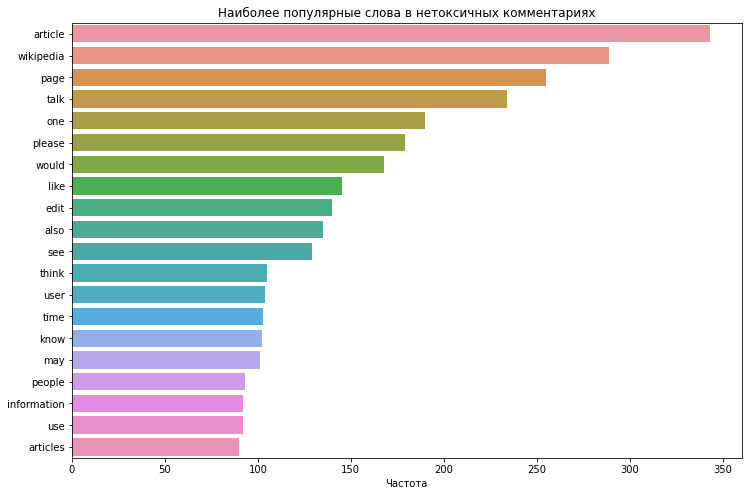

In [ ]:
# Посмотрим на 20 популярные слова в нетоксичных комментариях
plot_pop_words(corpus_nontoxic)
plt.title('Наиболее популярные слова в нетоксичных комментариях')
plt.show()

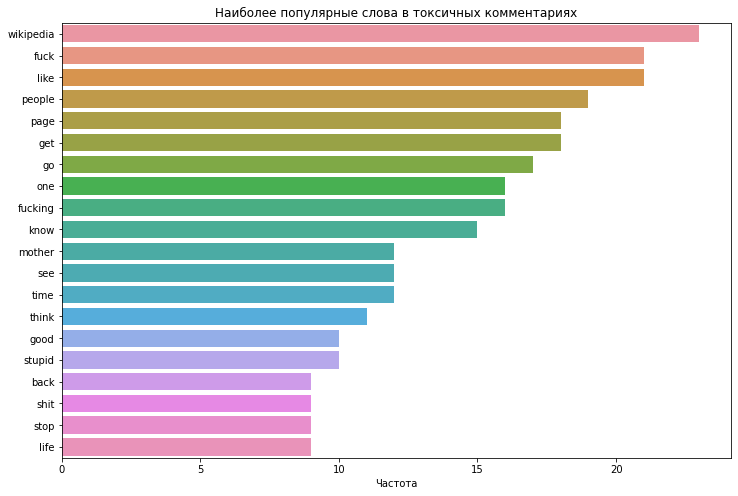

In [ ]:
# Посмотрим на 20 популярные слова в токсичных комментариях
plot_pop_words(corpus_toxic)
plt.title('Наиболее популярные слова в токсичных комментариях')
plt.show()

* В обоих классах встречаются похожие слова, как например, Wikipedia или people.
* Однако среди токсичных комментариях встречаются также же и негативно окрашенные слова. При этом, частота таких слов меньше, что, вероятно связано, с дисбалансом классов.
* Таким образом, классы уже отличаются по встречаемости слов, а также по их длине.
* Далее проведем токенизацию текстов.


### Подготовка данных к обучению модели

In [ ]:
%%time
tokenized = comments_1['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True,truncation=True))

CPU times: user 1.17 s, sys: 7 ms, total: 1.18 s
Wall time: 1.19 s


In [ ]:
# Проверим длину строк
tokenized.shape

(1000,)

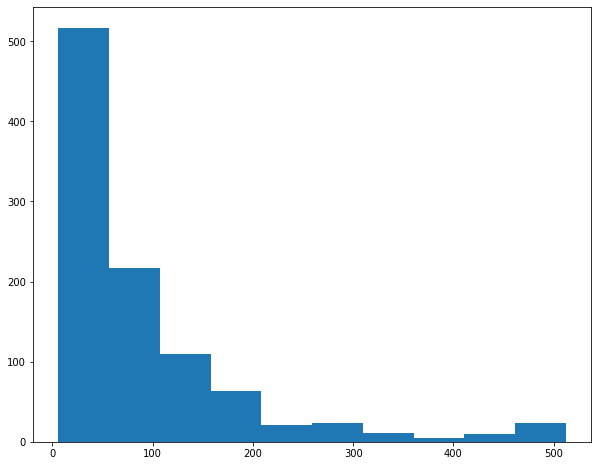

In [ ]:
# Посмотрим на длину токенов
tokenized.str.len().hist(grid=False, figsize=(10,8))

plt.show()

* Как и ожидалось, обрезка прошла по 512, что значит, что 75% данных комментариев в обеих группах входит в эту выборку токенов.
* Применим `padding` с самой длиной длиной строки.

In [ ]:
%%time
max_len =max([len(arr) for arr in tokenized.values])

# применим padding к векторам, чтобы длины текстов в корпусе были равны

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

CPU times: total: 46.9 ms
Wall time: 33.9 ms


In [ ]:
# применим маску, чтобы оставить только важные токены 
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
# Проверим длины
print(tokenized.shape)
print(padded.shape)
print(attention_mask.shape)


(1000,)
(1000, 512)
(1000, 512)


* Получили 512 переменных.
* Получим контекстуальные эмбеддинги, используя предобученный словарь.

In [ ]:
%%time
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
# Переводим в тензоры токены одинаковой длины.

        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
# Переводим в векторы-тензоры маски с 1 и 0.

        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])


# Применяем обученную модель, которая переведет в эмбединги маски и padded.       
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 1h 4min 54s
Wall time: 12min 34s


* Сохраним полученные эмбеддинги в признаки для предсказания модели.

In [ ]:
features = np.concatenate(embeddings)
features.shape

(1000, 768)

### Вывод
* Таблица `comments` содержит два типа текстов, токсичные и нетоксичные. Токсичных комментариев меньше и они короче. В негативных комментариях встречается нецензурная лексика и слова, набранные заглавными буквами.
* Из таблицы выбрано первые 1000 строк для отработки метода получения эмбеддингов через `BERT`.

* Извлечены контекстуальные эмбеддинги с помощью предобученного словаря `unitary/toxic-bert`.
* Данные готовы для обучения моделей классификации.

## Обучение

In [ ]:
# Извлечем целевой признак
target = comments_1['toxic']
target.shape

(1000,)

In [ ]:
# Разделим выборку попалам с учётом дисбалансов классов
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.5, 
                                                    random_state=12345, 
                                                    stratify=target)

In [ ]:
# Проверим сколько в выборке осталось токсичных классов
print('Количество комментариев из разных классов в тренировочной выборке', y_train.value_counts())
print()
print('Количество комментариев из разных классов в тестовой выборке', y_train.value_counts())

Количество комментариев из разных классов в тренировочной выборке 0    446
1     54
Name: toxic, dtype: int64

Количество комментариев из разных классов в тестовой выборке 0    446
1     54
Name: toxic, dtype: int64


* Количество комментариев разных классов представлено одинаковое количество.


### Logistic Regression

* Проверим предсказание токсичности комментариев на Логистической регрессии.
* В связи с дисбалансом классов будем использовать метрику `precision`.

In [ ]:
%%time
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced')
f1_lr = cross_val_score(model_lr, X_train, y_train, cv=4, scoring='f1').mean()
print(f'F1 Лоистической регрессии {round(f1_lr, 3)}')

F1 Лоистической регрессии 0.925
CPU times: total: 188 ms
Wall time: 196 ms


* Логистическая регрессия быстро обучается и даёт точность метрики `F1` 0,935, что выше ожидаемой 0,75. 

### Random Forest

In [ ]:
%%time
# Параметры
param_grid = {'n_estimators': [10, 33, 100, 1000],
               'max_depth': [2, 10, 20]
             }



rf = RandomForestClassifier(random_state=12345, class_weight='balanced')

rf_RandomGrid = RandomizedSearchCV(estimator=rf, param_distributions = param_grid,
                               cv = 3, scoring='f1', verbose=10, n_jobs=2).fit(X_train, y_train)
             



Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 250 ms
Wall time: 9.48 s


In [ ]:
print(rf_RandomGrid.best_params_)
print(f'F1 Случайного леса {round(rf_RandomGrid.best_score_, 3)}')
print(rf_RandomGrid.best_estimator_)



{'n_estimators': 100, 'max_depth': 2}
F1 Случайного леса 0.963
RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=12345)


* Случайный Лес обучается дольше, чем Логистическая регрессия и даёт точность метрики `F1` 0,963, что выше ожидаемой 0,75 и выше Логистической регрессии. 

### CatBoost

In [ ]:
# Разобъем выборку на три части.
# Сначала получим тренировочную и вторую часть, которую позже разобъем на валидационную и тестовую.
X_train, X_v_t, y_train, y_v_t = train_test_split(features, target, 
                                                  test_size=0.5, 
                                                  stratify=target,
                                                  random_state=12345)

In [ ]:
# Получим тестовую и валидационные выборки
X_valid, X_test, y_valid, y_test = train_test_split(X_v_t, y_v_t, 
                                                  test_size=0.5, 
                                                  stratify=y_v_t,
                                                  random_state=12345)

In [ ]:
# Создадим пулы данных для выборок
train_pool = Pool(X_train, y_train, cat_features=None)
valid_pool = Pool(X_valid, y_valid, cat_features=None)
test_pool = Pool(X_test, y_test, cat_features=None)

In [ ]:
%%time

# Проверим разные гиперпараметры
model_cb = CatBoostClassifier(auto_class_weights = 'Balanced', loss_function='Logloss', eval_metric='F1' , thread_count=2, verbose=300)

params = {'learning_rate': [0.1],
        'depth': [4, 8],
          'iterations':[100, 500],
          
          
          
        
         }


randomized_search_result = model_cb.randomized_search(params,
                                                   train_pool,
                                                   plot=True,
                                                   cv=3, 
                                                n_iter=1)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9776414	test: 0.9674620	best: 0.9674620 (0)	total: 55.8ms	remaining: 27.9s
300:	learn: 1.0000000	test: 0.9867257	best: 0.9867257 (30)	total: 14.6s	remaining: 9.66s
499:	learn: 1.0000000	test: 0.9867257	best: 0.9867257 (30)	total: 24.3s	remaining: 0us

bestTest = 0.9867256637
bestIteration = 30

0:	loss: 0.9867257	best: 0.9867257 (0)	total: 24.4s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.9753695	test: 0.9279438	best: 0.9279438 (0)	total: 53.5ms	remaining: 26.7s
300:	learn: 1.0000000	test: 0.9714286	best: 0.9714286 (28)	total: 15s	remaining: 9.89s
499:	learn: 1.0000000	test: 0.9714286	best: 0.9714286 (28)	total: 24.7s	remaining: 0us

bestTest = 0.9714285714
bestIteration = 28

Training on fold [1/3]
0:	learn: 0.9721768	test: 0.9834437	best: 0.9834437 (0)	total: 54.2ms	remaining: 27.1s
300:	learn: 1.0000000	test: 0.9966443	best: 0.9966443 (44)	total: 14.9s	remaining: 9.85s
499:	learn: 1.0000000	test: 0.9966443	best: 0.9966443 (44)	total: 24.

### Вывод
* `CatBoost` демонстрируем самую высокую оценку `F1`, равную 0,973, что выше, чем предыдущие модели.

## Тестирование модели

* Проведем тестирование лучшей модели.

In [ ]:
model_cb.get_params()

{'loss_function': 'Logloss',
 'thread_count': 2,
 'verbose': 300,
 'auto_class_weights': 'Balanced',
 'eval_metric': 'F1',
 'depth': 4,
 'iterations': 500,
 'learning_rate': 0.1}

In [ ]:
%%time
# Обучим модель

model_cb = CatBoostClassifier(**model_cb.get_params(), od_type='Iter',  od_wait=100)


model_cb.fit(
    train_pool, eval_set=valid_pool,
    plot=True,
    use_best_model=True,

)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9769989	test: 0.9461179	best: 0.9461179 (0)	total: 56.8ms	remaining: 28.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9744537815
bestIteration = 40

Shrink model to first 41 iterations.
CPU times: total: 13.8 s
Wall time: 6.94 s


In [ ]:
# Получим предсказание
target_names = ['Нетоксичные комментарии', 'Токсичные комментарии']
prediction_cb = model_cb.predict(X_test)
print(classification_report(y_test, prediction_cb, target_names=target_names))



                         precision    recall  f1-score   support

Нетоксичные комментарии       1.00      0.98      0.99       223
  Токсичные комментарии       0.84      0.96      0.90        27

               accuracy                           0.98       250
              macro avg       0.92      0.97      0.94       250
           weighted avg       0.98      0.98      0.98       250



* На тестовой выборке лучшая модель демонстриует оценку `F1` 0,90.

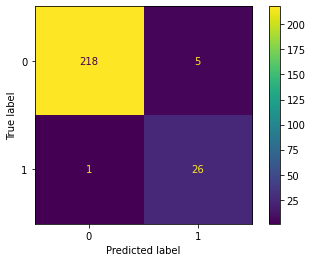

In [ ]:
# Посмотрим матрицу ошибок
cm = confusion_matrix(y_test, prediction_cb, labels=model_cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model_cb.classes_)
disp.plot()

* Из таблицы видно, что большая часть данных модель предсказывает верно, однако есть несколько ошибок.

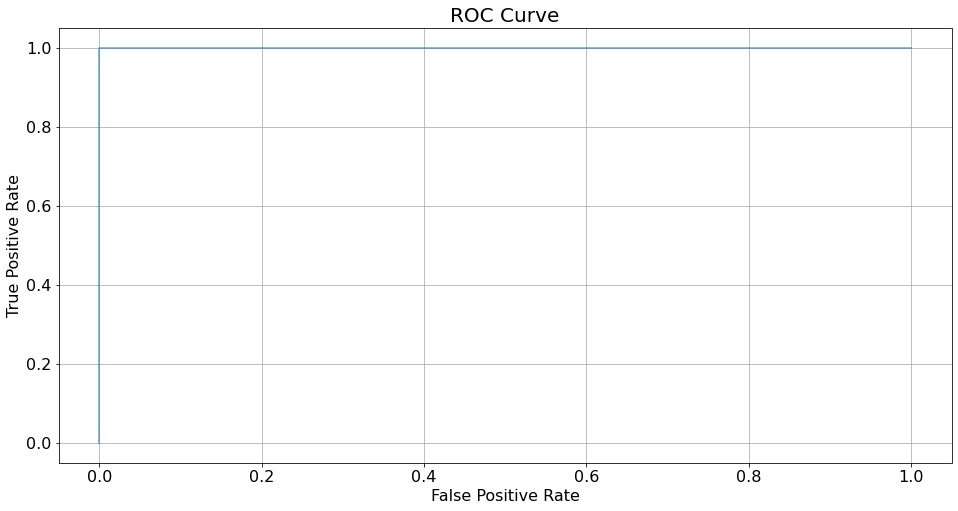

0.9950174389636273

In [ ]:
# Посмотрим график ROC кривой
catboost_pool = Pool(X_test, prediction_cb, cat_features=None)

(fpr, tpr, thresholds) = get_roc_curve(model_cb, catboost_pool, plot=True)

# Посмотрим на площадь по кривой
predictions_cb_proba = model_cb.predict_proba(X_test)
roc_auc_score(y_test, predictions_cb_proba[:,1])


* Площадь под кривой 0,995.

## Выводы

* Проведена классификация текстов на небольшой выборке в 1000 строк.
* Выборка имеет дисбаланс классов, поэтому при обучении моделей была соблюдена разница в весах классов.
* Получены контекстуальные эмбеддинги с помощью предобученного словаря `unitary/toxic-bert` на токсичных комментариях от `BERT`.
* Проведен поиск лучшей модели классификации токсичности текстов.
* Выбрана лучшая модель `CatBoost`, точность предсказания которой по `F1` метрики составила 0.91.
* Таким образом, с 91% уверенностью можно определять класс текста.